# Sentiment Analysis with Twitter data

In this notebook we develop a Sentiment Analyzer using Twitter data. We intent to classify the sentiment of the Tweet writer as Negative or Positive.

We will use the data from the article: [https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf], which we downloaded from the Kaggle repository: [https://www.kaggle.com/kazanova/sentiment140].  And base or analysis following the general lines drawn in the github repository [https://github.com/ayushoriginal/Sentiment-Analysis-Twitter]. As additional examples on Twitter Sentiment analysis we will use the following notebooks/blogs: [https://www.kaggle.com/mohamednabill7/sentiment-analysis-of-twitter-data], [https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners], [https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/], [https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk].

Our analysis will be divided in two phases:

1. Collection and preprocessing of data.

2. Train the data on different classification models, perform hyper parameter tunning and cross validation. 

___
## Collection and preprocessing of data

### Data collection
We collect data of the article: [https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf], the Kaggle repository: [https://www.kaggle.com/kazanova/sentiment140].

Note that this data set only contains tweets with positive or negative sentiments.
![Collecting Data](prtscreen/CollectingData.png "Collecting Data")

### Preprocessing Data
#### Data exploration
In this stage we load some basic python libraries, the collected data and begin to familiarize with the data. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None

 data set info after dropping duplicates 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1583691 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1583691 non-null  int64 
 1   text       1583691 non-null  object
dtypes: int64(1), object(1)
memory usage: 36.2+ MB
None


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

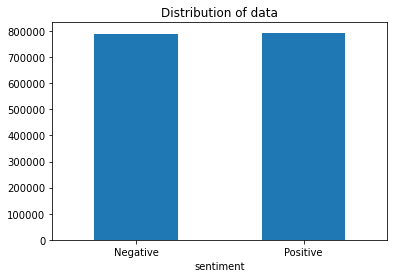

In [1]:
#Utility libraries
import numpy as np  #standard numerical library
import pandas as pd #for data manipulation 

#plotting
import matplotlib.pyplot as plt

#Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

print(dataset.info())

# Removing the unnecessary columns. (Keep sentiment and text)
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding. (positive sentiment is labeled as 4, we change to 1, negative sentiment still 0)
dataset['sentiment'] = dataset['sentiment'].replace(4,1)
# Drop duplicates
dataset = dataset.drop_duplicates()
print('\n data set info after dropping duplicates \n')
print(dataset.info())

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

___
#### Feature reduction

It is important to normalize the text by applying a series of pre-processing steps. As we can see in the following figure, we are not interested in some part of the text, as the **USER** or possible **URLs**. Also a variety of **Emoticons** actually map to the same word/idea ( for example " :) " " (: " " :-) " " (-: " are all variants of the same word/idea " smile(y) ").  To detect this elements in a tweet, and more, we will use the python library of regular expressions [https://docs.python.org/3/library/re.html].  
![Tweet parts example](prtscreen/tweet_parts.png "Tweet parts example")

In [2]:
import re

# HASHTAGS 
find_hashtag = re.compile(r'#(\w+)') #takes the alphanumeric characters (and symbol " _ ") after symbol " # "
def hashtag_replace(re_match):
    return '_HASHTAG_' + re_match.groups()[0]

# USERS
find_user = re.compile(r"@(\w+)")

# URLs
find_url = re.compile(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*|(ftp://)[^ ]*)")

# SEARCH SYMBOLS
find_symbols = re.compile(r"[^\w\s]+") # not alphanumeric nor spaces

# REPEATING LETTERS like hurrryyyy mapped to hurryy
find_MultipleLetters = re.compile(r"(.)\1\1+", re.IGNORECASE);
def MultipleLetters_replace(re_match):
	return re_match.groups()[0]*2

# EMOJIS
find_emojis = {
        '_SMILE': re.compile(r'(:-[)}\]]|:[)}\]]|[({\[]:|[({\[]-:)'),
        '_LAUGH': re.compile(r'(:-D|:D|X-D|XD|xD)'),
        '_LOVE':  re.compile(r'(<3|:\*)'),
        '_WINK':  re.compile(r'(;-[)}\]]|;[)}\]]|;-D|;D|[({\[];|[({\[]-;)'),
        '_SAD':   re.compile(r'(:-[({\[]|:[({\[]|[)}\]]:|[)}\]]-:)'),
        '_CRY':   re.compile(r'(:,[({\[]|:\'[({\[]|:"[({\[]|:[({\[][({\[])')
    }

# PUNCTUATIONS
find_punctuations = {
        '_EXCL':    re.compile(r'(!|¡)'),
        '_QUES':    re.compile(r'(\?|¿)'),
        '_ELLP':    re.compile(r'(\.\.\.|…)'),
    }


# PROCESS ALL    
def ProcessRegex(text):
    
    text = re.sub( find_hashtag, hashtag_replace, text )
    text = re.sub( find_user,    ' _USER ',       text )
    text = re.sub( find_url,     ' _URL ',        text )

    for emoji in find_emojis.keys():
        text = re.sub(find_emojis[emoji],' _EMOJI'+emoji+' ', text)

    text = text.replace('\'','')

    for punctuation in find_punctuations.keys():
        text = re.sub(find_punctuations[punctuation], ' _PUNCTUATION'+punctuation+' ', text)
        
    text = re.sub( find_symbols, '', text )
    text = re.sub( find_MultipleLetters, MultipleLetters_replace, text )

    return text

Lets check the code:

In [3]:
assert( ProcessRegex('Hello World #coding') == 'Hello World _HASHTAG_coding' )
assert( ProcessRegex('Hi @you') == 'Hi  _USER ' )
assert( ProcessRegex('this is an URL https://github.com/ayushoriginal/Sentiment-Analysis-Twitter') == 'this is an URL  _URL ' )
assert( ProcessRegex('hurrryyyy') == 'hurryy' )
assert( ProcessRegex('Hello sad world ]-:') == 'Hello sad world  _EMOJI_SAD ' )
assert( ProcessRegex('Hi!') == 'Hi _PUNCTUATION_EXCL ' )
assert( ProcessRegex('F*ck ;)') == 'Fck  _EMOJI_WINK ' )

Lets see if we reduced the number of words (features)

In [4]:
words_tweet = ( set(x.split()) for x in dataset['text'] )
words = set.union( *words_tweet )
nu_words_raw = len(words)
print( 'raw number of "words" :', nu_words_raw )

dataset['text_clean'] = dataset['text'].apply( ProcessRegex )
words_tweet = ( set(x.split()) for x in dataset['text_clean'] )
words = set.union( *words_tweet )
nu_words_clean = len(words)
print( 'clean number of "words" :', nu_words_clean )

print( 'feature reduced in ', nu_words_clean/nu_words_raw*100, '%' )

raw number of "words" : 1350598
clean number of "words" : 468336
feature reduced in  34.676195285347674 %


___
####  Stemming

According to [https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf] adding POS tags does not improve the model, even more, according to this review about lemmatizing [https://opendatagroup.github.io/data%20science/2019/03/21/preprocessing-text.html] many times is better to not Lemmatize. In our study we will use a stemming approach, similarly to [https://github.com/ayushoriginal/Sentiment-Analysis-Twitter]. We apply Steaming algorithm from python library nltk [https://www.nltk.org/api/nltk.stem.porter.html].

In [5]:
import nltk

stemmer = nltk.stem.PorterStemmer()

def ProcessStemmer(text):
    
    words = [word if(word[0:1]=='_') else stemmer.stem(word) for word in text.split() if len(word) >= 2] 
    text_b = ' '.join(words)
    
    if text_b:
        return text_b
    else:
        return text

In [6]:
assert( ProcessStemmer("He glanced up from his computer when she came into his office") ==
       'he glanc up from hi comput when she came into hi offic' )

we see if our number of words is further reduced 

In [7]:
dataset['text_stemm'] = dataset['text_clean'].apply( ProcessStemmer )
words_tweet = ( set(x.split()) for x in dataset['text_stemm'] )
words = set.union( *words_tweet )
nu_words_stemm = len(words)
print( 'stemm number of "words" :', nu_words_stemm )

print( 'stemm reduced to ', nu_words_stemm/nu_words_clean*100, '%' )

stemm number of "words" : 319078
stemm reduced to  68.13014587817293 %


___
#### Ngrams
We have interest in the frequency of words, bigrams and trigrams.  

In [8]:
def NgramFreq(list_texts):
    
    unigrams_fd = nltk.FreqDist()
    bigrams_fd = nltk.FreqDist()
    trigrams_fd = nltk.FreqDist()
    
    for text in list_texts:
        
        words = text.split()
        
        words_uni = words
        unigrams_fd.update( words )
        
        words_bi = [ ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
        bigrams_fd.update( words_bi )
        
        words_tri = [ ','.join(map(str,bg)) for bg in nltk.trigrams(words) ]
        trigrams_fd.update( words_tri )
    
    return unigrams_fd, bigrams_fd, trigrams_fd

with this we can get the cumulative distribution of the NGrams.

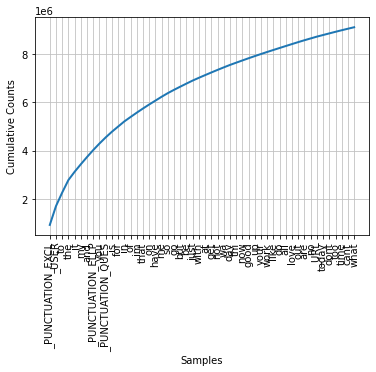

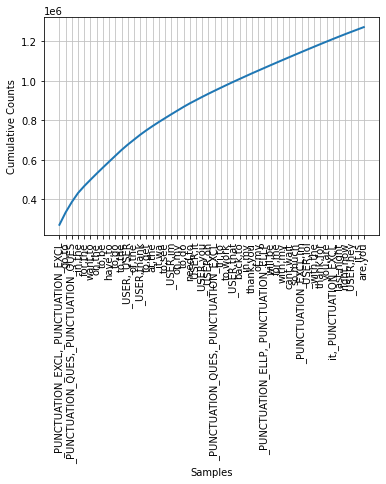

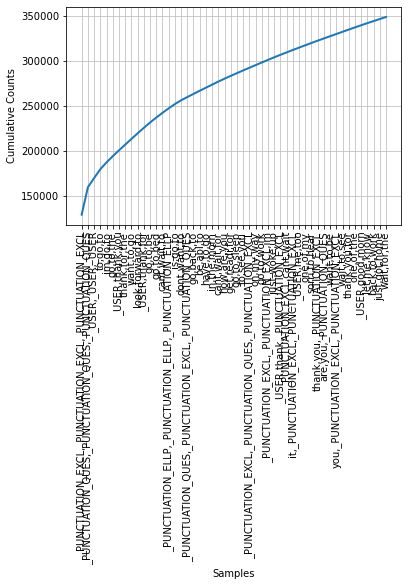

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [10]:
uni_g,bi_g,tri_g = NgramFreq(dataset['text_stemm'])
uni_g.plot( 50, cumulative=True )
bi_g.plot( 50, cumulative=True )
tri_g.plot( 50, cumulative=True )

In [11]:
def NGramsFeatures(text):
    
    words = text.split()
    dummies = {}    
    
    for item in words:
        dummies[f'_UNIGRAM_{item}'] = 1
   
    for item in nltk.bigrams(words):
        dummies[f'_BIGRAM_{item[0]}-{item[1]}'] = 1
        
    for item in nltk.trigrams(words):
        dummies[f'_TRIGRAM_{item[0]}-{item[1]}-{item[2]}'] = 1
        
    return dummies

test last function

In [12]:
lari = NGramsFeatures('1 2 3 1')
print('\n Ngrams \n');_=[ print(ii, lari[ii]) for ii in lari.keys() ]


 Ngrams 

_UNIGRAM_1 1
_UNIGRAM_2 1
_UNIGRAM_3 1
_BIGRAM_1-2 1
_BIGRAM_2-3 1
_BIGRAM_3-1 1
_TRIGRAM_1-2-3 1
_TRIGRAM_2-3-1 1


___
#### Negation

The need negation detection in sentiment analysis can be illustrated by the difference in the meaning of the phrases, "This is good" vs. "This is not good" However, the negations occurring in natural language are seldom so simple. Handling the negation consists of two tasks: i) Detection of explicit negation cues and ii) the scope of negation of these words.

In [13]:
#DETECTION OF EXPLICIT NEGATION
# Regular expression for negation by Christopher Potts
negations = r"""
    (?:
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint
        )$
    )
    |
    n't"""

find_negation = re.compile(negations, re.VERBOSE)

#SCOPE OF NEGATION
'''
    Words immediately preceding and following the negation cues are the most negative
    and the words that come farther away do not lie in the scope of negation of such cues.
    We define left and right negativity of a word as the chances that meaning of that word is actually the opposite.
    Left negativity depends on the closest negation cue on the left and similarly for Right negativity.
'''
def NegationFeatures(text):
    
    words = text.split()   
    words_r = [word for word in words]
    words_r.reverse()
    
    left = np.zeros(len(words))
    right = np.copy(left)
    prev = 0.0
    prev_r = 0.0
    for i, (word, word_r) in enumerate(zip(words,words_r)):
        if( bool(find_negation.search(word)) ):
            prev = 1.0
        if( bool(find_negation.search(word_r)) ):
            prev_r = 1.0
        left[i] = prev
        right[i] = prev_r
        prev = max(0.0,prev-0.1)#prev*0.9
        prev_r = max(0.0,prev_r-0.1)
    
    scope = zip(
        ['_NEG_L_'+w for w in  words] + ['_NEG_R_'+w for w in  words_r],
        np.hstack((left,right)) ) 
    
    scope_dict = {}
    
    N=10
    for (key,val) in scope:
        if val != 0.0:
            if scope_dict.get(key):
                for ii in range(N):
                    key_ii=key+f'_{ii}'
                    if scope_dict.get(key_ii):
                        continue
                    else:    
                        scope_dict[key_ii]=val
                        break
                    scope_dict[key+f'_FAIL']=val    
            else:
                scope_dict[key]=val
           
    return scope_dict        

see this function

In [14]:
lari = NegationFeatures('1 1 2 1 not 1 2 1 1')
_ = [ print(ii, lari[ii]) for ii in lari.keys() ]

_NEG_L_not 1.0
_NEG_L_1 0.9
_NEG_L_2 0.8
_NEG_L_1_0 0.7000000000000001
_NEG_L_1_1 0.6000000000000001
_NEG_R_not 1.0
_NEG_R_1 0.9
_NEG_R_2 0.8
_NEG_R_1_0 0.7000000000000001
_NEG_R_1_1 0.6000000000000001


Finally we write a function that captures *Ngram* and *Negation*

In [15]:
def ExtractFeatures(text):
    features = {}
    
    ngrams_features = NGramsFeatures(text)
    features.update( ngrams_features )
    
    negation_features = NegationFeatures(text)
    features.update( negation_features )
    
    return features

and see this function

In [16]:
lari=ExtractFeatures('This is good')
print('\n Ngrams \n');_=[ print(ii, lari[ii]) for ii in lari.keys() if re.match('_(U|B|T)',ii) ]
print('\n Left negativity \n');_=[ print(ii, lari[ii]) for ii in lari.keys() if re.match('_NEG_L',ii) ]
print('\n Right negativity \n');_=[ print(ii, lari[ii]) for ii in lari.keys() if re.match('_NEG_R',ii) ]


lari=ExtractFeatures('This is not good')
print('\n Ngrams \n');_=[ print(ii, lari[ii]) for ii in lari.keys() if re.match('_(U|B|T)',ii) ]
print('\n Left negativity \n');_=[ print(ii, lari[ii]) for ii in lari.keys() if re.match('_NEG_L',ii) ]
print('\n Right negativity \n');_=[ print(ii, lari[ii]) for ii in lari.keys() if re.match('_NEG_R',ii) ]


 Ngrams 

_UNIGRAM_This 1
_UNIGRAM_is 1
_UNIGRAM_good 1
_BIGRAM_This-is 1
_BIGRAM_is-good 1
_TRIGRAM_This-is-good 1

 Left negativity 


 Right negativity 


 Ngrams 

_UNIGRAM_This 1
_UNIGRAM_is 1
_UNIGRAM_not 1
_UNIGRAM_good 1
_BIGRAM_This-is 1
_BIGRAM_is-not 1
_BIGRAM_not-good 1
_TRIGRAM_This-is-not 1
_TRIGRAM_is-not-good 1

 Left negativity 

_NEG_L_not 1.0
_NEG_L_good 0.9

 Right negativity 

_NEG_R_not 1.0
_NEG_R_is 0.9
_NEG_R_This 0.8


___
## Next step

1. Divide data in training and validation set
2. (Optional) In training data we can drop unigrams, bigrams, trigrams, that are rare or common
3. Train a model with training data
4. Predict for validation set and see confusion matrix and metrics
5. (Optional) Compare models when we drop ngrams in training set and when we do not drop them


### Dividing data

In [ ]:
from sklearn.model_selection import train_test_split

d_train, d_val = train_test_split(dataset,test_size=0.2,random_state=2)

### Dropping some values of d_train 

In [ ]:
from collections import defaultdict

def NgramSeries(list_texts):
    
    unigrams = defaultdict(int)
    bigrams = defaultdict(int)
    trigrams = defaultdict(int)
    
    for text in list_texts:
        
        words = text.split()
        
        words_uni = words
        for item in words_uni:
            unigrams[item] += 1
                
        words_bi = [ ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
        for item in words_bi:
            bigrams[item] += 1
                
        words_tri = [ ','.join(map(str,bg)) for bg in nltk.trigrams(words) ]        
        for item in words_tri:
            trigrams[item] += 1        
    
    return pd.Series(unigrams), pd.Series(bigrams), pd.Series(trigrams)

In [ ]:
uni_g,bi_g,tri_g = NgramSeries(d_train['text_stemm'])

#percentage of Ngrams that appers n times in train set
print('\n n       percentage \n')
print(uni_g.value_counts()/uni_g.count())
print(bi_g.value_counts()/bi_g.count())
print(tri_g.value_counts()/tri_g.count())